In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

def excludeProjects(df: pd.DataFrame):
    df = df[df['LOC'] > 0]
    df = df[~df['Path'].str.match(r'.*src\\test.*')]
    df = df[~df['Path'].str.match(r'.*src\\tests.*')]
    return df

def plotThresholdsCurve(axis, metric, percentiles):
    plt.figure(figsize=(8, 6))
    plt.plot(axis['LOC_weights_norm'], axis[metric])
    for percentile in percentiles:
        per = axis[axis['LOC_weights_norm'] >= percentile][metric].values[0]
        plt.plot(np.interp(per, axis[metric], axis['LOC_weights_norm']), per, 'ro')
        plt.text(np.interp(per, axis[metric], axis['LOC_weights_norm']), per, f'{per:.2f}', color='red')
    plt.title('ECDF plot with percentiles')
    plt.xlabel('Percentile rank')
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()

def getOutliers(dataset, dimensions):
    band=True
    outliers = pd.DataFrame()
    for dimension in dimensions:
        aux = systemsThresholds(dataset, dimension)
        threshold = upper_bound(aux['90th'])
        aux = aux[aux['90th'] >= threshold]
        if outliers.shape[0] == 0 and band:
            outliers = aux.copy()
            band=False
        else: 
            outliers = pd.concat([outliers, aux])#outliers[outliers['System'].isin(aux['System'])]
    
    return outliers['System']

def systemsThresholds(dataset, metric):
    thresholds = pd.DataFrame()
    entitiesAgg = generateAlvesThresholds(dataset, metric)[2]
    projects = entitiesAgg['Repository'].unique()
    for id in range(len(projects)):
        systemValues = entitiesAgg[entitiesAgg['Repository'] == projects[id]].copy()
        systemValues = systemValues.sort_values(by=metric)
        systemValues['LOC_weights_cum'] = systemValues['LOC_weights'].cumsum().to_frame()

        p70 = systemValues[systemValues['LOC_weights_cum'] >= 0.70][metric].values[0]
        p80 = systemValues[systemValues['LOC_weights_cum'] >= 0.80][metric].values[0]
        p90 = systemValues[systemValues['LOC_weights_cum'] >= 0.90][metric].values[0]
        systemThresholds = pd.DataFrame([{'System': projects[id], '70th': p70, '80th': p80, '90th': p90}])
        thresholds = pd.concat([thresholds, systemThresholds])
    
    return thresholds
    
def upper_bound(data):    
    
    # Calculate the IQR of the data
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Define the upper bound for non-outliers
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers

    return upper_bound

In [2]:
def plotSystemsDistribution(projects: pd.DataFrame, entitiesAgg: pd.DataFrame, metric, percentiles):
    plt.figure(figsize=(8, 6))
    
    for id, project in projects.iterrows():

        projectData = entitiesAgg[entitiesAgg['Repository'] == project['url']]

        projectData = projectData.sort_values(by=metric)
        projectData['LOC_weights_cum'] = projectData['LOC_weights'].cumsum().to_frame()

        plt.plot(projectData['LOC_weights_cum'], projectData[metric], color='lightgrey')

    axis = entitiesAgg.groupby(metric)['LOC_weights_norm'].sum().to_frame()

    axis['cdf'] = axis['LOC_weights_norm'].cumsum()

    plt.plot(axis['cdf'], axis.index, color='black')

    # Calculate percentiles
    
    th70 = axis[axis['cdf'] >= 0.7].index.values[0]
    th80 = axis[axis['cdf'] >= 0.8].index.values[0]
    th90 = axis[axis['cdf'] >= 0.9].index.values[0]
    percentiles = [th70, th80, th90]
    

    for percentile in percentiles:
        plt.plot(np.interp(percentile, axis.index, axis['cdf']), percentile, 'ro')
        plt.text(np.interp(percentile, axis.index, axis['cdf']), percentile, f'{percentile:.2f}', color='red')
    

    plt.title('ECDF plot systems')
    plt.xlabel('Percentile rank')
    plt.ylabel(metric)
    plt.grid(False)
    plt.show()

In [3]:
def generateAlvesThresholds(df, metric):
    # 1. Metrics Extraction
    total_loc = df.groupby('Repository')['LOC'].sum()
    df = df.join(total_loc, on='Repository', rsuffix='_total')

    # 2. Weight Ratio Calculation
    df['LOC_weights'] = df['LOC'] / (df['LOC_total'])

    # 3. Entity aggregation
    entitiesAgg = df.groupby(['Repository', metric])['LOC_weights'].sum().reset_index()

    # 4. System aggregation
    systems = total_loc.shape[0]
    entitiesAgg['LOC_weights_norm'] = entitiesAgg['LOC_weights']/systems
    systemAgg = entitiesAgg.groupby(metric)['LOC_weights_norm'].sum().reset_index()
    axis = systemAgg.copy()

    # 5. Weight Ratio Aggregation
    systemAgg = systemAgg.sort_values(by=metric)
    axis['LOC_weights_norm'] = systemAgg['LOC_weights_norm'].cumsum().to_frame()

    # 6. Thresholds derivaton
    p70 = axis[axis['LOC_weights_norm'] >= 0.7][metric].values[0]
    p80 = axis[axis['LOC_weights_norm'] >= 0.8][metric].values[0]
    p90 = axis[axis['LOC_weights_norm'] >= 0.9][metric].values[0]

    metricRow = pd.DataFrame([{'Metric': metric, '70th': p70, '80th': p80, '90th':p90}])
    return metricRow, axis, entitiesAgg

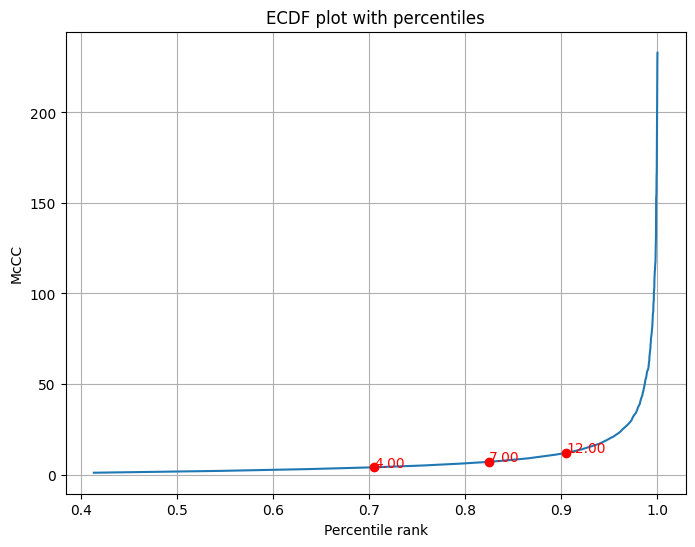

Number of projects: 112


,Metric,70th,80th,90th
0,LOC,28,42,74
0,McCC,4,7,12
0,NUMPAR,2,2,3
0,LOC,361,560,1023
0,CBO,12,18,29
0,DIT,1,2,2
0,LCOM5,3,4,6
0,NM,30,43,76
0,NOC,0,0,1
0,RFC,39,58,102


In [16]:
import SizeThresholds

datasetPath = './datasets/caseStudy/currentSample'

classDataset = pd.read_csv(f'{datasetPath}/class.csv')
methodDataset = pd.read_csv(f'{datasetPath}/method.csv')
githubDataset = pd.read_csv(f'{datasetPath}/sample2.csv')


classDataset = excludeProjects(classDataset)
methodDataset = excludeProjects(methodDataset)

#outiers = getOutliers(classDataset, ['LOC', 'WMC'])
#classDataset = classDataset[~classDataset['Repository'].isin(outiers)]
#methodDataset = methodDataset[~methodDataset['Repository'].isin(outiers)]

classMetrics = ['LOC', 'CBO', 'DIT', 'LCOM5','NM', 'NOC','RFC', 'WMC']
methodMetrics = ['LOC', 'McCC', 'NUMPAR']
results = pd.DataFrame(columns=['Metric', '70th', '80th', '90th'])

for metric in methodMetrics:
    results = pd.concat([results, generateAlvesThresholds(methodDataset, metric)[0]])

for metric in classMetrics:
       
    results = pd.concat([results, generateAlvesThresholds(classDataset, metric)[0]])


plotThresholdsCurve(generateAlvesThresholds(methodDataset, 'McCC')[1], 'McCC', [0.7, 0.8, 0.9])

print(f'Number of projects: {len(classDataset["Repository"].unique())}')

results

Thresholds by system

Number of projects: 78


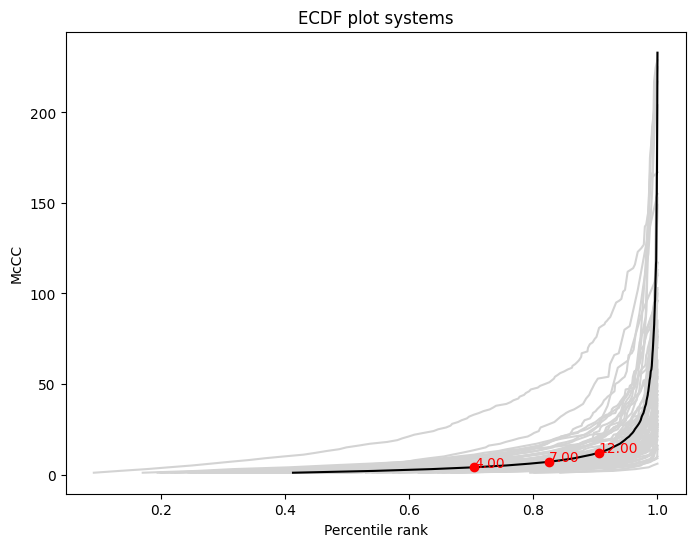

,System,70th,80th,90th
0,https://github.com/commercetools/commercetools...,1,1,2
0,https://github.com/line/line-bot-sdk-java,1,1,2
0,https://github.com/jcabi/jcabi-github,1,2,2
0,https://github.com/hub4j/github-api,2,2,4
0,https://github.com/TechEmpower/FrameworkBenchm...,2,3,4
...,...,...,...,...
0,https://github.com/opendcs/opendcs,11,17,28
0,https://github.com/cqframework/clinical_qualit...,9,14,29
0,https://github.com/TownyAdvanced/Towny,11,16,35
0,https://github.com/minima-global/Minima,14,23,53


In [17]:
metric = 'McCC'
dataset = methodDataset.copy()

results = systemsThresholds(dataset, metric)

#results = results[~results['System'].isin(outliers)]
#dataset = dataset[~dataset['Repository'].isin(outliers)]
#githubDataset = githubDataset[~githubDataset['url'].isin(outliers)]


#plotThresholdsCurve(generateAlvesThresholds(methodDataset, 'McCC')[1], 'McCC', [0.7, 0.8, 0.9])
results = results.sort_values(by=['90th', '80th', '70th'])

print(f'Number of projects: {results.shape[0]}')

entitiesAgg = generateAlvesThresholds(dataset, metric)[2]

plotSystemsDistribution(githubDataset, entitiesAgg, metric, [])

results

COSINE SIMILARITY


-------->LOC

KS = KstestResult(statistic=0.11578947368421053, pvalue=5.7543008745504025e-06, statistic_location=0.6861697454574851, statistic_sign=1)
KS = KstestResult(statistic=0.015789473684210527, pvalue=0.999786353547988, statistic_location=0.7212236064052782, statistic_sign=-1)

-------->McCC

KS = KstestResult(statistic=0.10543130990415335, pvalue=0.06160547093650467, statistic_location=0.615303849094415, statistic_sign=1)
KS = KstestResult(statistic=0.022364217252396165, pvalue=0.9999988799426343, statistic_location=0.6826928381869788, statistic_sign=-1)


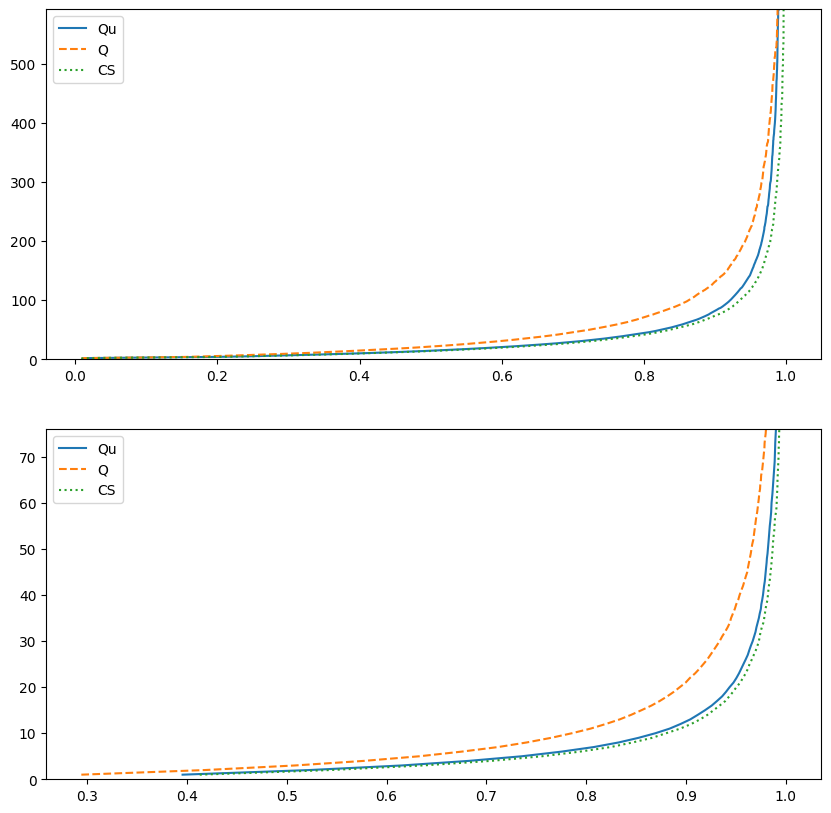

In [18]:
import SampleBuilder as SB
from scipy.spatial.distance import cosine, euclidean, jensenshannon
import scipy.stats as sp

def varghaDelaney(a, b, scaled=True):
    m = len(a)
    n = len(b)
    U = sp.rankdata(np.concatenate([a, b]))
    R1 = U[:m].sum()
    R2 = U[m:].sum()
    v = (R1/m - (m+1)/2)/n
    if scaled:
        return abs((v-0.5)*2)
    else:
        return v  


mdim = ['LOC', 'McCC']#['LOC', 'WMC', 'NM', 'CBO']
dims = len(mdim)

fig, axs = plt.subplots(dims, figsize=(10, 5*dims))

i = 0

sample1 = 'qualitasUpdated'
sample2 = 'qualitas'
sample3 = 'currentSample'

sm1 = pd.read_csv(f'./datasets/caseStudy/{sample1}/method.csv')
sm2 = pd.read_csv(f'./datasets/caseStudy/{sample2}/method.csv')
sm3 = pd.read_csv(f'./datasets/caseStudy/{sample3}/method.csv')
sc1 = pd.read_csv(f'./datasets/caseStudy/{sample1}/class.csv')
sc2 = pd.read_csv(f'./datasets/caseStudy/{sample2}/class.csv')
sc3 = pd.read_csv(f'./datasets/caseStudy/{sample3}/class.csv')

sm1 = excludeProjects(sm1)
sm2 = excludeProjects(sm2)
sm3 = excludeProjects(sm3)
sc1 = excludeProjects(sc1)
sc2 = excludeProjects(sc2)
sc3 = excludeProjects(sc3)

for metric in mdim:

    print(f'\n-------->{metric}\n')

    agg1 = generateAlvesThresholds(sm1, metric)[2]
    agg2 = generateAlvesThresholds(sm2, metric)[2]
    agg3 = generateAlvesThresholds(sm3, metric)[2]

    sys1 = agg1.groupby(metric)['LOC_weights_norm'].sum().reset_index()[[metric, 'LOC_weights_norm']]
    sys2 = agg2.groupby(metric)['LOC_weights_norm'].sum().reset_index()[[metric, 'LOC_weights_norm']]
    sys3 = agg3.groupby(metric)['LOC_weights_norm'].sum().reset_index()[[metric, 'LOC_weights_norm']]

    agg3 = pd.merge(sys1, sys2, on=metric, how='outer')
    agg3 = pd.merge(agg3, sys3, on=metric, how='outer')
    agg3.fillna(0, inplace=True)

    '''
    maxValX = agg3[agg3["LOC_weights_norm_x"] == 0][metric].values[0]
    maxValY = agg3[agg3["LOC_weights_norm_y"] == 0][metric].values[0]
    maxVal = min([maxValX, maxValY])
    '''

    agg3 = agg3.sort_values(metric)

    agg3['cdf_x'] = agg3["LOC_weights_norm_x"].cumsum()
    agg3['cdf_y'] = agg3["LOC_weights_norm_y"].cumsum()
    agg3['cdf_z'] = agg3["LOC_weights_norm"].cumsum()



    axs[i].plot(agg3["cdf_x"], agg3[metric])
    axs[i].plot(agg3["cdf_y"], agg3[metric], linestyle='--')
    axs[i].plot(agg3["cdf_z"], agg3[metric], linestyle=':')
    axs[i].legend(['Qu', 'Q', 'CS'])

    lim = agg3[agg3['cdf_x'] >= 0.99][metric].values[0]

    axs[i].set_ylim(0, lim)

    i+=1
    '''
    jen1 = np.append(agg3[agg3[metric] < maxVal]["LOC_weights_norm_x"].values, [agg3[agg3[metric] >= maxVal]["LOC_weights_norm_x"].sum()])
    jen2 = np.append(agg3[agg3[metric] < maxVal]["LOC_weights_norm_y"].values, [agg3[agg3[metric] >= maxVal]["LOC_weights_norm_y"].sum()])
    ks1 = jen1.cumsum()
    ks2 = jen2.cumsum()
    '''

    #print(f'VD = {varghaDelaney(sm1[metric], sm2[metric])}')
    #print(f'JS = {jensenshannon(agg3["LOC_weights_norm_x"], agg3["LOC_weights_norm_y"])}')
    print(f'KS = {sp.ks_2samp(agg3["cdf_x"], agg3["cdf_y"], method="exact")}')
    print(f'KS = {sp.ks_2samp(agg3["cdf_x"], agg3["cdf_z"], method="exact")}')
    #print(f'{metric} VG: {varghaDelaney(jen1, jen2)}')

plt.show()


CORRELATION ANALYSIS

In [19]:
from scipy.stats import spearmanr

sourcemeter = pd.read_csv('../datasets/caseStudy/ThresholdsExperiment/DT/currentsample1/method.csv')[['Repository', 'LOC']]
loc_by_system = sourcemeter.groupby('Repository').sum().reset_index()

loc_by_system = loc_by_system.sort_values('Repository')


sample = pd.read_csv('../datasets/caseStudy/ThresholdsExperiment/DT/currentsample1/sample.csv')
sample = sample.sort_values('url')

#calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(loc_by_system['LOC'], sample['totalSize'])

#print Spearman rank correlation and p-value
print('Spearman rank correlation:', rho)
print('p-value:', p)

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/caseStudy/ThresholdsExperiment/DT/currentsample1/method.csv'